In [49]:
import pandas as pd
import numpy as np
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fastai.imports import *

from matplotlib import pyplot as plt
import glob2 as glob
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest\
#from sklearn.tree import export_graphviz

In [50]:

# size_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2015*.csv')], ignore_index=True)
# trip_2015 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2015*.csv')], ignore_index = True)

# size_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2016*.csv')], ignore_index=True)
# trip_2016 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2016*.csv')], ignore_index = True)

size_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/size_2017*.csv')], ignore_index=True)
trip_2017 = pd.concat([pd.read_csv(f) for f in glob.glob('Past3years/trip_2017*.csv')], ignore_index = True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (26,39,65,73) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [51]:
trip_2017.columns

Index(['prim2_common', 'prim1_common', 'strat_id', 'psu_id', 'YEAR', 'REG_RES',
       'ST_RES', 'CNTY_RES', 'ST', 'CNTY', 'INTSITE', 'MODE_F', 'MODE_FX',
       'AREA', 'AREA_X', 'HRSF', 'ADD_HRS', 'FFDAYS12', 'FFDAYS2', 'CNTRBTRS',
       'NUM_TYP2', 'NUM_TYP3', 'NUM_TYP4', 'NUM_TYP6', 'PARTY', 'FIRST',
       'ID_CODE', 'SUB_REG', 'WAVE', 'CATCH', 'ON_LIST', 'BOAT_HRS',
       'NUM_TYP9', 'telefon', 'COASTAL', 'new_list', 'kod', 'ASG_CODE',
       'MODE_ASG', 'PRT_CODE', 'CELLTYPE', 'fshinsp_a', 'num_fish_a', 'region',
       'strat_interval', 'month', 'COUNTY', 'TIME', 'tsn1', 'tsn2', 'DISTKEYS',
       'GEAR', 'PVT_RES', 'SEP_FISH', 'ADD_PH', 'F_BY_P', 'date1', 'DIST',
       'prim1', 'prim2', 'MODE2001', 'TURTLE', 'GENDER', 'REEFCODE', 'AGE',
       'AREA_NC', 'ART_REEF', 'muni_res', 'muni_trp', 'wp_int', 'VAR_ID',
       'ARX_METHOD', 'ALT_FLAG', 'LEADER', 'fl_reg'],
      dtype='object')

Many of the ID codes are messed up and aren't actually numbers...they end in XX instead. We will make these into NaN

In [52]:
ids=[]
for idno in trip_2017.ID_CODE:
    try: ids.append(int(idno))
    except: ids.append(np.nan)
        
trip_2017['new_id']=ids


## Choose the columns that aren't obviously cheating:


In [53]:
size_cols = ['AREA_X', 'ID_CODE', 'MODE_FX', 'SUB_REG', 'common'].copy()
trip_cols = ['AREA', 'BOAT_HRS', 'CNTRBTRS',
            'FFDAYS12', 'new_id','month'].copy()

In [54]:
size2017 = size_2017[size_cols].copy()
trip2017 = trip_2017[trip_cols].copy()


In [55]:
merged = pd.merge(size2017,trip2017,how='inner', left_on=['ID_CODE'], right_on=['new_id'])

In [56]:
print(sum(merged.common.isnull()))
print(len(merged.common))

35662
176809


Drop the fish that you don't have any name for. We can't use these for training.

In [57]:
mask = merged.common.isnull()
data = merged[mask==False]

fill the NA values of "primary fish sought" using "NONE" for NA values

In [58]:
# data.prim1_common.fillna(value='NONE', inplace=True)

Drop the ID_CODE column and anything else that is leaky data

In [59]:
data.drop(columns=['new_id', 'ID_CODE'], inplace=True)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [60]:
merged.head()

,AREA_X,ID_CODE,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,new_id,month
0,5,1748920170906001,3,4,NaN,C,NaN,1.0,30.0,1.748920e+15,9
1,5,1748920170906002,3,4,NaN,C,NaN,1.0,50.0,1.748920e+15,9
2,5,1748920170906003,3,4,NaN,C,NaN,1.0,50.0,1.748920e+15,9
3,5,1748920170908001,3,4,NaN,C,NaN,1.0,10.0,1.748920e+15,9
4,5,1748920170908002,3,4,NaN,C,NaN,1.0,20.0,1.748920e+15,9


In [61]:
data.head()

,AREA_X,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,month
9,5,3,4,ATLANTIC SILVERSIDE,C,NaN,1.0,100.0,9
13,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9
14,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9
15,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9
16,5,3,4,ATLANTIC MENHADEN,C,NaN,1.0,20.0,9


In [62]:
# data.AREA_X.unique()
for x in data:
    print(x)
    print(data[x].unique())

AREA_X
[5 1 2 3 4]
MODE_FX
[3 4 5 7]
SUB_REG
[4 5 6 7]
common
['ATLANTIC SILVERSIDE' 'ATLANTIC MENHADEN' 'SCUP' 'TAUTOG' ... 'NEEDLEFISH FAMILY' 'YELLOWMOUTH GROUPER'
 'BLACKFIN SNAPPER' 'SQUIRRELFISH FAMILY']
AREA
['C' '1' '2' '4' '3' '5' 'V' 'B' 'A' 'E' 'F' 'D' 'H' 'G' 'L' 'K' 'J']
BOAT_HRS
[ nan  8.5  8.   6.   4.5  6.5  7.   7.5  5.   5.5  4.   9.5  9.  12.   3.   3.5 10.  24.   2.5 10.5  2.  11.5 11.
 13.   1.   1.5 14.5 21.5 16.5 12.5 14.  15.  20.  36.  99.8 16.  15.5 18.  13.5 17.  22.   4.9 21.  99.9]
CNTRBTRS
[ 1.  2.  3.  0.  9.  4.  5. 15.  8.  7.  6. 11. 13. 10. 12. 17. 19. 20.]
FFDAYS12
[100.  20.  99.  50. ... 215.  67. 274. 336.]
month
[ 9 10  7  8  2  1  6  5  4  3 11 12]


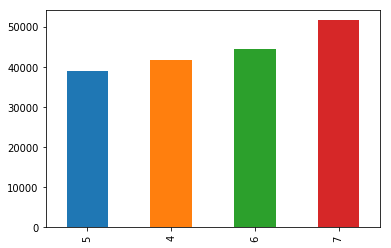

In [63]:
by_area = merged['SUB_REG'].value_counts()
by_area.sort_values(inplace=True)
by_area[-10:].plot(kind='bar')

In [64]:
#get the most common fish for each sub-region
# merged.tail()

mask = merged['SUB_REG']==4
region_1 = merged[mask].copy()
# region_1
counts = region_1['common'].value_counts()
counts.sort_values(inplace=True)

counts[-1]
# counts[-10:].plot(kind='bar')

10019

In [65]:
# Take the count of the most common fish in each region. If you always guess that, you'll get it right
# the same number of times that it appears. Add those up, and divide out of the total fish, and there's your baseline
# Region 4: 10019
# Region 5: 5137
# Region 6: 2718
# Region 7: 4003
accuracy = (10019+5137+2718+4003)/len(merged)*100
print(accuracy)

12.373238918833316


### So, the total accuracy if you just guess the most common fish in each region, is 12.4%

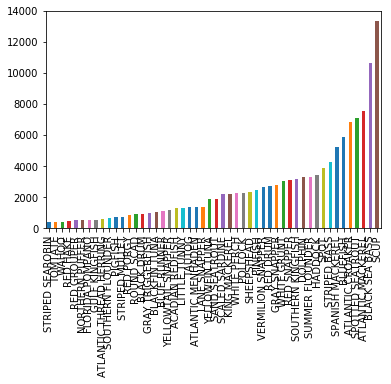

In [66]:
counts = merged['common'].value_counts()
counts.sort_values(inplace=True)

counts[-50:].plot(kind='bar')

## Don't make predictions for every single kind of fish. Make predictions for the top 50 kinds of fish, and then everything else becomes 'other'

In [67]:
print(sum(counts>500))
print(500/merged.shape[0]*100)
print(500/counts.sum()*100)

46
0.2827910343930456
0.3542406143949216


As seen above, there are only 46 species that had more than 500 catches. If a species was caught less than 500 times, it represents less than 0.5% of the catches.

In [68]:
fish = counts.sum()
rates = [x/fish*100 for x in counts]
rates[-10:]

[2.422297321232474,
 2.731903618213636,
 3.020963959559891,
 3.714567082545148,
 4.171537475114597,
 4.836801348948259,
 5.018172543518459,
 5.327070359270831,
 7.54532508661183,
 9.446888704683769]

In [69]:
df_count = pd.DataFrame()
df_count['counts'] = counts
df_count['common'] = counts.index
totals = pd.merge(merged, df_count, how="inner")
totals.head()
#df_count.head()

,AREA_X,ID_CODE,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,new_id,month,counts
0,5,1748920170908007,3,4,ATLANTIC SILVERSIDE,C,NaN,1.0,100.0,1.748920e+15,9,13
1,5,1664920170913001,3,5,ATLANTIC SILVERSIDE,4,NaN,1.0,12.0,1.664920e+15,9,13
2,5,1766120170921003,3,5,ATLANTIC SILVERSIDE,F,NaN,1.0,85.0,1.766120e+15,9,13
3,5,1770020170901010,3,5,ATLANTIC SILVERSIDE,D,NaN,1.0,12.0,1.770020e+15,9,13
4,5,1770020170901012,3,5,ATLANTIC SILVERSIDE,D,NaN,1.0,0.0,1.770020e+15,9,13


In [74]:
# totals['COMMON_CND'][totals['counts']>= 500] = 
totals['common'][totals['counts'] < 100] = 'OTHER'

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [75]:
totals.loc[1000:1050]

,AREA_X,ID_CODE,MODE_FX,SUB_REG,common,AREA,BOAT_HRS,CNTRBTRS,FFDAYS12,new_id,month,counts
1000,5,1752820170513001,7,4,ATLANTIC MENHADEN,A,4.5,1.0,5.0,1.752820e+15,5,1344
1001,5,1766520170609002,7,4,ATLANTIC MENHADEN,A,8.0,1.0,16.0,1.766520e+15,6,1344
1002,5,1766520170609002,7,4,ATLANTIC MENHADEN,A,8.0,1.0,16.0,1.766520e+15,6,1344
1003,5,1766520170609002,7,4,ATLANTIC MENHADEN,A,8.0,1.0,16.0,1.766520e+15,6,1344
1004,5,1766520170609002,7,4,ATLANTIC MENHADEN,A,8.0,1.0,16.0,1.766520e+15,6,1344
1005,5,1766520170609002,7,4,ATLANTIC MENHADEN,A,8.0,1.0,16.0,1.766520e+15,6,1344
1006,5,1767120170616001,7,4,ATLANTIC MENHADEN,A,5.0,1.0,4.0,1.767120e+15,6,1344
1007,5,1767120170616001,7,4,ATLANTIC MENHADEN,A,5.0,1.0,4.0,1.767120e+15,6,1344
1008,5,1767120170616001,7,4,ATLANTIC MENHADEN,A,5.0,1.0,4.0,1.767120e+15,6,1344
1009,5,1767120170616001,7,4,ATLANTIC MENHADEN,A,5.0,1.0,4.0,1.767120e+15,6,1344


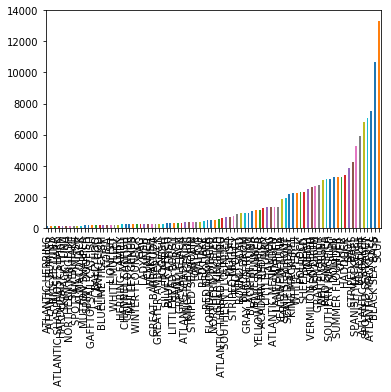

In [76]:
counts = totals['common'].value_counts()
counts.sort_values(inplace=True)

counts[:].plot(kind='bar')

In [78]:
len(counts)

90

In [36]:
def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

In [37]:
# data.dtypes

In [38]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 53000
# n_trn = len(df)-n_valid
# raw_train, raw_valid = split_vals(data, n_trn)
# X_train, X_valid = split_vals(df, n_trn)
# y_train, y_valid = split_vals(y, n_trn)

# X_train.shape, y_train.shape, X_valid.shape

In [39]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [40]:
# data2.prim1_common.astype('category')
cats=['SUB_REG', 'AREA', 'AREA_X', 'MODE_FX', 'month','common']

for item in cats:
    data[item]=data[item].astype('category')

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [41]:
data.dtypes

AREA_X      category
MODE_FX     category
SUB_REG     category
common      category
AREA        category
BOAT_HRS     float64
CNTRBTRS     float64
FFDAYS12     float64
month       category
dtype: object

In [42]:
# train_cats(data2)
df, y, nas = proc_df(data, 'common')

In [45]:
df.columns
simple_df = df['SUB_REG']

In [46]:
n_valid = 40000
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(data, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((101147, 9), (101147,), (40000, 9))

## Here, I do a simple model using only the location data

In [54]:
simple_model = RandomForestClassifier(oob_score=True, n_jobs=-1)
arr=simple_df.as_matrix()
arr = arr.reshape(-1,1)

%time simple_model.fit(arr, y)
#print_score(simple_model)

/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/ensemble/forest

CPU times: user 7.54 s, sys: 11.9 s, total: 19.5 s
Wall time: 35.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [56]:
simple_model.oob_score_

0.15381127477027495

So, if I only use the sub-region, I get about 15% accuracy. Question: Is this necessarily the same as saying, "get all the fish from sub-region X, always pick the most common fish for that region". This question was answered above, and it's not. It's slightly better than that strategy.

In [65]:
from sklearn.linear_model import LogisticRegression

logmod = LogisticRegression()
logmod.fit(X_train, y_train)


/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/lubuntu/anaconda3/envs/project/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [113]:
m = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=30, max_depth=7, max_features=.5,
                           min_samples_leaf=10)
%time m.fit(df, y)
m.oob_score

CPU times: user 20.3 s, sys: 23.6 s, total: 43.9 s
Wall time: 55.1 s


True

In [114]:
m.oob_score_

0.4123148207188251

In [115]:
m.probab

array([  0,   1,   2,   3, ..., 311, 312, 313, 314], dtype=int16)

get the list of probabilities, get the list of classes, put them both in a dataframe and then iterate?

# Maybe you can make a confusion matrix? Because you're so confused? Lol no because it would be relevant

evaluate the model

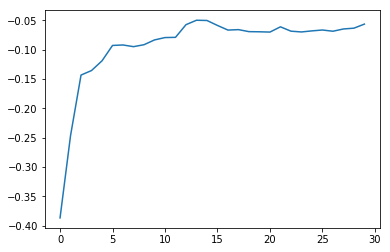

In [116]:
from sklearn import metrics
#get a list of all the trees (estimators), call predict on it. list of arrays(all predictions of one tree) of predictions 
#then concat them on an axis
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#take the mean of all the predictions
preds[:,0], np.mean(preds[:,0]), y_valid[0]

#take the mean of the prediction, taking trees up to the i-th tree. 
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(30)]);

If we look at how adding more trees affects the accuracy, it is clear that adding lots more trees isn't making it better. Let's go back to the default of 10 or just stick with 20

In [117]:
import pickle 

with open('cute_model.pkl','wb') as pickle_file:
    pickle.dump(m, pickle_file)

In [ ]:
m.feature_importances_

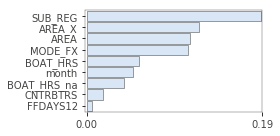

In [119]:
imp = importances(m, df, y, n_samples=-1)
viz = plot_importances(imp)
viz.view()

In [41]:
# data.common.cat.codes
# .unique()

In [23]:
# mapping = []
# for column in data2:
#     df = pd.DataFrame()
#     df[f'{column}']=data2[column].unique()
#     try:
#         df['code']=data2[column].cat.codes.unique()
#     except:
#         df['code']=data[column].max()
#     mapping.append(df)

In [27]:
# with open('mapping.pkl','wb') as pickle_file:
#     pickle.dump(mapping, pickle_file)